# Educational Reading Level Classification

## Import Libraries

In [ ]:
pip install -r requirements.txt

In [2]:
import os
import torch
import random
import numpy as np
import pandas as pd
from typing import Tuple
from pathlib import Path
from datasets import Dataset
import matplotlib.pyplot as plt
import datasets, evaluate, accelerate
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, EarlyStoppingCallback, Trainer
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification

## Load Data

In [68]:
# Load fiction and nonfiction data
all_fiction_data = pd.read_csv("data/fiction.csv")
all_nonfiction_data = pd.read_csv("data/nonfiction.csv")

In [69]:
# Shuffle data randomly
all_fiction_data = all_fiction_data.sample(frac=1)
all_nonfiction_data = all_nonfiction_data.sample(frac=1)

## Clean Data

In [70]:
# Rename columns for consistency
all_fiction_data = all_fiction_data.rename(columns={"passage": "text",
                                                    "reading_level": "labels"})
all_nonfiction_data = all_nonfiction_data.rename(columns={"passage": "text",
                                                          "reading_level": "labels"})

In [71]:
# Check unique classes
all_fiction_data['labels'].unique()

array(['Elementary', 'Middle ', 'High', 'Middle', 'High '], dtype=object)

In [72]:
# Combine classes that are the same
map_levels = {
    'Middle ': 'Middle',
    'High ': 'High'
}

all_fiction_data['labels'] = all_fiction_data['labels'].replace(map_levels)
all_nonfiction_data['labels'] = all_nonfiction_data['labels'].replace(map_levels)

In [73]:
# Check amount of data in each class
all_fiction_data['labels'].value_counts()

,count
labels,
Middle,1746
High,1741
Elementary,1661


In [74]:
# View data
all_fiction_data

,text,labels
1176,"""What is it?""",Elementary
3362,"“I am a Woodman, and made of tin. Therefore I ...",Middle
1090,"“I thought all the fairies were dead,” Mrs. Da...",Elementary
4815,"It came to my knowledge, through what passed b...",High
4373,“And wherefore?” rejoined the physician. “Wher...,High
...,...,...
4426,“But what are you going to do?” she asked him....,High
466,This time the voice came from so close that Mi...,Elementary
3092,He did. He even figured to a nicety what would...,Middle
3772,That night Buck faced the great problem of sle...,High


In [76]:
# Convert to Hugging Face Dataset
all_fiction_data = Dataset.from_pandas(all_fiction_data)
all_nonfiction_data = Dataset.from_pandas(all_nonfiction_data)

## Prepare Data for Classification

In [77]:
id2label = {0: "Elementary", 1: "Middle", 2: "High"}
label2id = {"Elementary": 0, "Middle": 1, "High": 2}

In [79]:
# Turn labels into 0, 1, or 2
def map_labels_to_number(example):
  example["labels"] = label2id[example["labels"]]
  return example

fiction_data = all_fiction_data.map(map_labels_to_number)
nonfiction_data = all_nonfiction_data.map(map_labels_to_number)

Map:   0%|          | 0/5148 [00:00<?, ? examples/s]

Map:   0%|          | 0/2086 [00:00<?, ? examples/s]

In [14]:
# Split data into training (70%), validation (15%), test (15%) sets

# Split fiction into train + temp
temp_split = fiction_data.train_test_split(test_size=0.3)

# Split temp into validation + test
val_test = temp_split["test"].train_test_split(test_size=0.5, seed=42)

fiction_data = {
    "train": temp_split["train"],
    "validation": val_test["train"],
    "test": val_test["test"]
}

In [15]:
fiction_data

{'train': Dataset({
     features: ['text', 'labels', '__index_level_0__'],
     num_rows: 3603
 }),
 'validation': Dataset({
     features: ['text', 'labels', '__index_level_0__'],
     num_rows: 772
 }),
 'test': Dataset({
     features: ['text', 'labels', '__index_level_0__'],
     num_rows: 773
 })}

## Prepare Tokenizers

In [16]:
roberta_tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="roberta-large",
                                                  use_fast=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [17]:
distilbert_tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
                                                     use_fast=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [18]:
xlnet_tokenizer = XLNetTokenizer.from_pretrained(pretrained_model_name_or_path="xlnet-base-cased",
                                                 use_fast=True)

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [19]:
ernie_tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path="nghuyong/ernie-2.0-en",
                                                use_fast=True)

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

In [49]:
def tokenize(examples, tokenizer):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

## Prepare Tokenized Datasets

In [21]:
roberta_train_tokenized = fiction_data["train"].map(
    lambda x: tokenize(x, roberta_tokenizer),
    batched=True
)

roberta_val_tokenized = fiction_data["validation"].map(
    lambda x: tokenize(x, roberta_tokenizer),
    batched=True
)
roberta_test_tokenized = fiction_data["test"].map(
    lambda x: tokenize(x, roberta_tokenizer),
    batched=True
)

Map:   0%|          | 0/3603 [00:00<?, ? examples/s]

Map:   0%|          | 0/772 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

In [22]:
distilbert_train_tokenized = fiction_data["train"].map(
    lambda x: tokenize(x, distilbert_tokenizer),
    batched=True
)
distilbert_val_tokenized = fiction_data["validation"].map(
    lambda x: tokenize(x, distilbert_tokenizer),
    batched=True
)
distilbert_test_tokenized = fiction_data["test"].map(
    lambda x: tokenize(x, distilbert_tokenizer),
    batched=True
)

Map:   0%|          | 0/3603 [00:00<?, ? examples/s]

Map:   0%|          | 0/772 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

In [23]:
xlnet_train_tokenized = fiction_data["train"].map(
    lambda x: tokenize(x, xlnet_tokenizer),
    batched=True
)
xlnet_val_tokenized = fiction_data["validation"].map(
    lambda x: tokenize(x, xlnet_tokenizer),
    batched=True
)
xlnet_test_tokenized = fiction_data["test"].map(
    lambda x: tokenize(x, xlnet_tokenizer),
    batched=True
)

Map:   0%|          | 0/3603 [00:00<?, ? examples/s]

Map:   0%|          | 0/772 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

In [24]:
ernie_train_tokenized = fiction_data["train"].map(
    lambda x: tokenize(x, ernie_tokenizer),
    batched=True
)
ernie_val_tokenized = fiction_data["validation"].map(
    lambda x: tokenize(x, ernie_tokenizer),
    batched=True
)
ernie_test_tokenized = fiction_data["test"].map(
    lambda x: tokenize(x, ernie_tokenizer),
    batched=True
)

Map:   0%|          | 0/3603 [00:00<?, ? examples/s]

Map:   0%|          | 0/772 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

## Set Up Evaluation Metric

In [100]:
accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
  """
  Computes the accuracy of a model by comparing the predictions and labels.
  """
  predictions, labels = predictions_and_labels

  # Get highest prediction probability of each prediction if predictions are probabilities
  if len(predictions.shape) >= 2:
    predictions = np.argmax(predictions, axis=1)

  return accuracy_metric.compute(predictions=predictions, references=labels)

In [103]:
eval_metrics = evaluate.load("mdocekal/precision_recall_fscore_accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    if len(predictions.shape) >= 2:
        predictions = np.argmax(predictions, axis=1)

    return eval_metrics.compute(predictions=predictions, references=labels)

## Set Up Models for Training

In [26]:
roberta_model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="roberta-large",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
distilbert_model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
xlnet_model = XLNetForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="xlnet-base-cased",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
ernie_model = BertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="nghuyong/ernie-2.0-en",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

You are using a model of type ernie to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nghuyong/ernie-2.0-en and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.output

In [30]:
# Count # parameters of the model
def count_params(model):
    """
    Count the parameters of a PyTorch model.
    """
    trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_parameters = sum(p.numel() for p in model.parameters())

    print({"trainable_parameters": trainable_parameters, "total_parameters": total_parameters})

In [31]:
count_params(roberta_model)
count_params(distilbert_model)
count_params(xlnet_model)
count_params(ernie_model)

{'trainable_parameters': 355362819, 'total_parameters': 355362819}
{'trainable_parameters': 66955779, 'total_parameters': 66955779}
{'trainable_parameters': 117311235, 'total_parameters': 117311235}
{'trainable_parameters': 109486083, 'total_parameters': 109486083}


All the parameters in all the model are trainable!

### Create Directory for Saving Models

In [32]:
# Create models directory
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

# Create model save paths
roberta_save_dir = Path(models_dir, "reading_level_text_classifier-roberta-large")
distilbert_save_dir = Path(models_dir, "reading_level_text_classifier-distilbert")
xlnet_save_dir = Path(models_dir, "reading_level_text_classifier-xlnet")
ernie_save_dir = Path(models_dir, "reading_level_text_classifier-ernie")

### Set Up Training Arguments

In [33]:
model_dirs = [roberta_save_dir,
              distilbert_save_dir,
              xlnet_save_dir,
              ernie_save_dir]

for model_dir in model_dirs:
    print(f"[INFO] Saving model checkpoints to: {model_dir}")

    # Create training arguments
    training_args = TrainingArguments(
        output_dir=model_dir,

        learning_rate=1e-5,
        weight_decay=0.05,
        warmup_ratio=0.1,

        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=1,
        num_train_epochs=5,

        fp16=True,

        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=3,
        load_best_model_at_end=True,

        no_cuda=False,

        logging_strategy="epoch",
        report_to="none",

        hub_private_repo=False,
    )

[INFO] Saving model checkpoints to: models/reading_level_text_classifier-roberta-large
[INFO] Saving model checkpoints to: models/reading_level_text_classifier-distilbert
[INFO] Saving model checkpoints to: models/reading_level_text_classifier-xlnet
[INFO] Saving model checkpoints to: models/reading_level_text_classifier-ernie


### Set Up Trainer Instances

In [34]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [35]:
roberta_trainer = Trainer(
    model=roberta_model,
    args=training_args,
    train_dataset=roberta_train_tokenized,
    eval_dataset=roberta_val_tokenized,
    tokenizer=roberta_tokenizer,
    compute_metrics=compute_accuracy
)

/tmp/ipython-input-2220557998.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  roberta_trainer = Trainer(


In [36]:
distilbert_trainer = Trainer(
    model=distilbert_model,
    args=training_args,
    train_dataset=distilbert_train_tokenized,
    eval_dataset=distilbert_val_tokenized,
    tokenizer=distilbert_tokenizer,
    compute_metrics=compute_accuracy
)

/tmp/ipython-input-1885591994.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  distilbert_trainer = Trainer(


In [37]:
xlnet_trainer = Trainer(
    model=xlnet_model,
    args=training_args,
    train_dataset=xlnet_train_tokenized,
    eval_dataset=xlnet_val_tokenized,
    tokenizer=xlnet_tokenizer,
    compute_metrics=compute_accuracy
)

/tmp/ipython-input-1088928813.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  xlnet_trainer = Trainer(


In [38]:
ernie_trainer = Trainer(
    model=ernie_model,
    args=training_args,
    train_dataset=ernie_train_tokenized,
    eval_dataset=ernie_val_tokenized,
    tokenizer=ernie_tokenizer,
    compute_metrics=compute_accuracy
)

/tmp/ipython-input-1806178208.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  ernie_trainer = Trainer(


## Training Text Classification Model

In [39]:
roberta_results = roberta_trainer.train()

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy
1,0.913700,0.611883,0.742228
2,0.553500,0.674553,0.818653
3,0.343000,0.887203,0.840674
4,0.153600,1.112401,0.843264
5,0.074400,1.058113,0.862694


In [50]:
distilbert_results = distilbert_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.364400,0.819892,0.796632
2,0.262400,0.819109,0.826425
3,0.142300,1.126045,0.796632
4,0.063400,1.005247,0.835492
5,0.046400,1.013264,0.838083


In [ ]:
xlnet_results = xlnet_trainer.train()

In [ ]:
ernie_results = ernie_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.064200,1.030112,0.449482
2,0.963600,0.924590,0.509067
3,0.909500,0.968322,0.529793
4,0.817600,0.879445,0.582902


## Save Models for Later Use

In [43]:
roberta_trainer.save_model(output_dir=roberta_save_dir)
distilbert_trainer.save_model(output_dir=distilbert_save_dir)
xlnet_trainer.save_model(output_dir=xlnet_save_dir)
ernie_trainer.save_model(output_dir=ernie_save_dir)

## Inspect Model Training Metrics

RoBERTa Training and Evaluation Metrics:


,loss,grad_norm,learning_rate,epoch,step
0,0.9137,19.408689,8.892452e-06,1.0,901
1,0.5535,22.237112,6.669956e-06,2.0,1802
2,0.3430,158.785645,4.447459e-06,3.0,2703
3,0.1536,3.082797,2.224963e-06,4.0,3604
4,0.0744,0.014462,2.466700e-09,5.0,4505


,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.611883,0.742228,9.3634,82.448,20.612,1.0,901
1,0.674553,0.818653,9.4516,81.679,20.420,2.0,1802
2,0.887203,0.840674,9.4181,81.970,20.492,3.0,2703
3,1.112401,0.843264,9.4183,81.968,20.492,4.0,3604
4,1.058113,0.862694,9.4789,81.444,20.361,5.0,4505



 ********** 




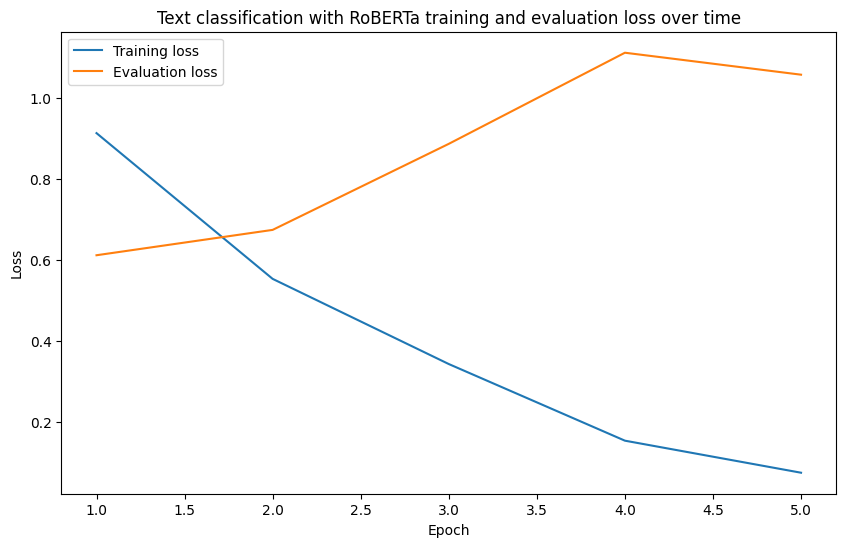

DistilBERT Training and Evaluation Metrics:


,loss,grad_norm,learning_rate,epoch,step
0,0.9045,5.314752,8.892452e-06,1.0,901
1,0.5462,0.979127,6.669956e-06,2.0,1802
2,0.3604,93.650719,4.447459e-06,3.0,2703
3,0.2354,0.319565,2.224963e-06,4.0,3604
4,0.1708,13.906199,2.466700e-09,5.0,4505


,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.701521,0.661917,2.3130,333.765,83.441,1.0,901
1,0.576315,0.769430,1.9404,397.863,99.466,2.0,1802
2,0.799873,0.783679,1.9379,398.364,99.591,3.0,2703
3,0.788725,0.818653,1.9359,398.783,99.696,4.0,3604
4,0.820951,0.814767,1.9522,395.454,98.864,5.0,4505



 ********** 




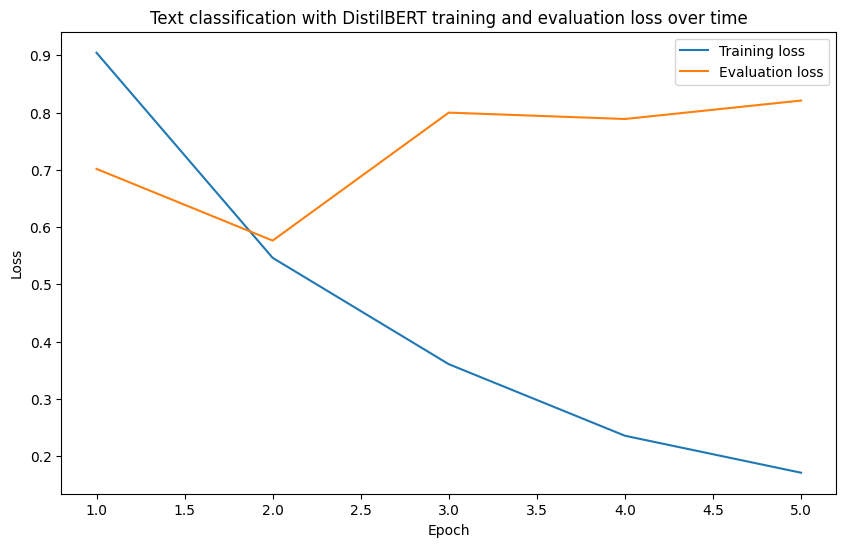

XLNet Training and Evaluation Metrics:


,loss,grad_norm,learning_rate,epoch,step
0,0.9443,25.680798,8.892452e-06,1.0,901
1,0.6613,58.749390,6.669956e-06,2.0,1802
2,0.4240,8.208356,4.447459e-06,3.0,2703
3,0.3046,129.581284,2.224963e-06,4.0,3604
4,0.1989,0.087472,2.466700e-09,5.0,4505


,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.733641,0.650259,7.0922,108.851,27.213,1.0,901
1,0.643284,0.731865,6.9734,110.707,27.677,2.0,1802
2,1.041487,0.737047,6.8886,112.070,28.017,3.0,2703
3,0.868770,0.817358,7.1414,108.102,27.025,4.0,3604
4,0.944943,0.830311,7.0711,109.176,27.294,5.0,4505



 ********** 




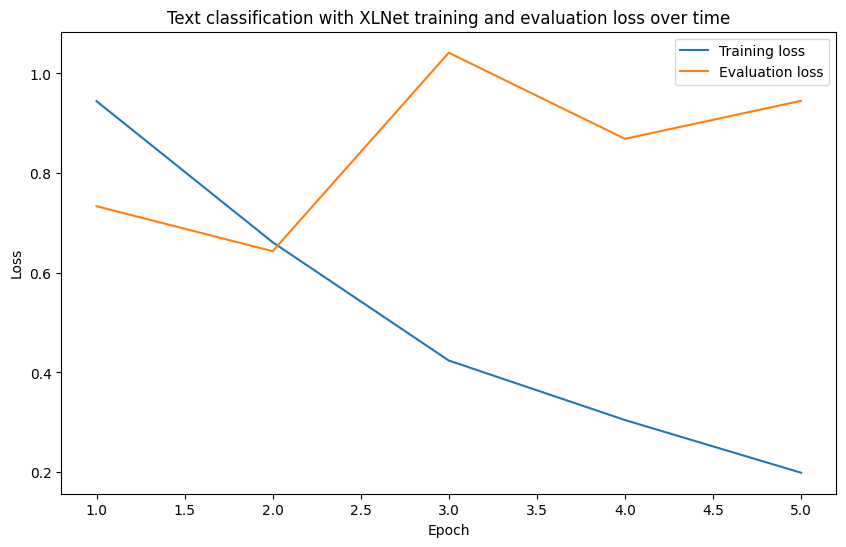

Ernie Training and Evaluation Metrics:


,loss,grad_norm,learning_rate,epoch,step
0,1.0642,7.093473,8.892452e-06,1.0,901
1,0.9636,39.467739,6.669956e-06,2.0,1802
2,0.9095,5.499647,4.447459e-06,3.0,2703
3,0.8176,22.745974,2.224963e-06,4.0,3604
4,0.7287,147.783508,2.466700e-09,5.0,4505


,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,1.030112,0.449482,3.5553,217.139,54.285,1.0,901
1,0.924590,0.509067,3.6083,213.951,53.488,2.0,1802
2,0.968322,0.529793,3.6170,213.435,53.359,3.0,2703
3,0.879445,0.582902,3.6131,213.669,53.417,4.0,3604
4,0.901683,0.613990,3.5564,217.075,54.269,5.0,4505



 ********** 




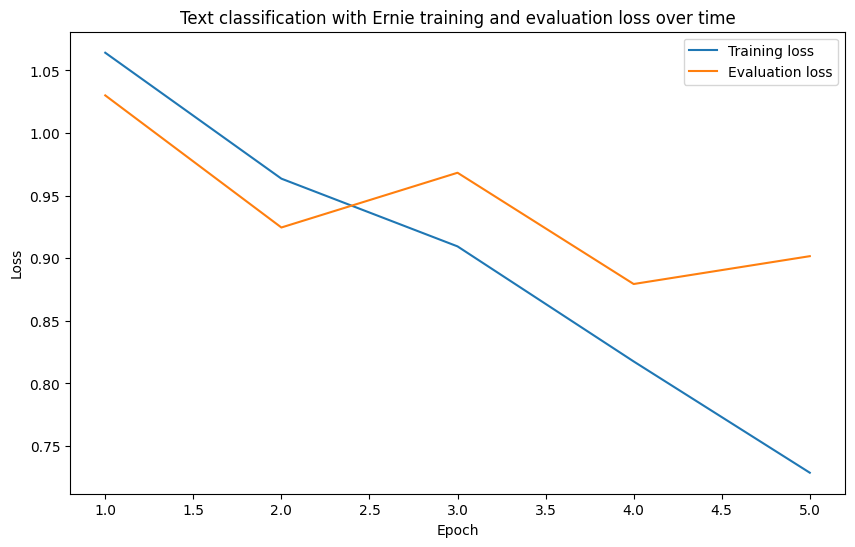

In [44]:
trainers = [roberta_trainer, distilbert_trainer, xlnet_trainer, ernie_trainer]
models = ["RoBERTa", "DistilBERT", "XLNet", "Ernie"]
for trainer, model in zip(trainers, models):
    # Get training history
    trainer_history_all = trainer.state.log_history
    trainer_history_metrics = trainer_history_all[:-1]
    trainer_history_training_time = trainer_history_all[-1]

    # Extract training and evaluation metrics
    trainer_history_training_set = []
    trainer_history_eval_set = []

    # Loop through metrics and filter for training and eval metrics
    for item in trainer_history_metrics:
        item_keys = list(item.keys())
        # Check to see if "eval" is in the keys of the item
        if any("eval" in item for item in item_keys):
            trainer_history_eval_set.append(item)
        else:
            trainer_history_training_set.append(item)

    # Create pandas DataFrames for the training and evaluation metrics
    trainer_history_training_df = pd.DataFrame(trainer_history_training_set)
    trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

    print(f"{model} Training and Evaluation Metrics:")
    display(trainer_history_training_df)
    display(trainer_history_eval_df)
    print("\n","*"*10, "\n\n")

    # Plot training and evaluation loss
    plt.figure(figsize=(10, 6))
    plt.plot(trainer_history_training_df["epoch"], trainer_history_training_df["loss"], label="Training loss")
    plt.plot(trainer_history_eval_df["epoch"], trainer_history_eval_df["eval_loss"], label="Evaluation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Text classification with {model} training and evaluation loss over time")
    plt.legend()
    plt.show()

Epoch=2 seems to produce the best model.

In [45]:
!zip -r /content/models.zip /content/models

  adding: content/models/ (stored 0%)
  adding: content/models/reading_level_text_classifier-roberta-large/ (stored 0%)
  adding: content/models/reading_level_text_classifier-roberta-large/training_args.bin (deflated 53%)
  adding: content/models/reading_level_text_classifier-roberta-large/model.safetensors (deflated 9%)
  adding: content/models/reading_level_text_classifier-roberta-large/vocab.json (deflated 59%)
  adding: content/models/reading_level_text_classifier-roberta-large/special_tokens_map.json (deflated 52%)
  adding: content/models/reading_level_text_classifier-roberta-large/tokenizer.json (deflated 82%)
  adding: content/models/reading_level_text_classifier-roberta-large/tokenizer_config.json (deflated 75%)
  adding: content/models/reading_level_text_classifier-roberta-large/config.json (deflated 51%)
  adding: content/models/reading_level_text_classifier-roberta-large/merges.txt (deflated 53%)
  adding: content/models/reading_level_text_classifier-ernie/ (stored 0%)
  ad

In [ ]:
from google.colab import files
files.download('/content/models.zip')

## Create final model

In [56]:
from datasets import concatenate_datasets
all_train_data = concatenate_datasets([
    fiction_data["train"],
    fiction_data["validation"]
])
final_save_dir = Path(models_dir, "reading_level_text_classifier-final")

final_train_tokenized = all_train_data.map(
    lambda x: tokenize(x, distilbert_tokenizer),
    batched=True
)
final_test_tokenized = fiction_data["test"].map(
    lambda x: tokenize(x, distilbert_tokenizer),
    batched=True
)

Map:   0%|          | 0/4375 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

In [106]:
# Create training arguments
training_args = TrainingArguments(
    output_dir=final_save_dir,

    learning_rate=1e-5,
    weight_decay=0.05,
    warmup_ratio=0.1,

    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=1,
    num_train_epochs=2,

    fp16=True,

    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,

    no_cuda=False,

    logging_strategy="epoch",
    report_to="none",

    hub_private_repo=False,
)

final_trainer = Trainer(
    model=distilbert_model,
    args=training_args,
    train_dataset=final_train_tokenized,
    eval_dataset=final_test_tokenized,
    tokenizer=distilbert_tokenizer,
)

/tmp/ipython-input-389457151.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_trainer = Trainer(


In [107]:
final_trainer.train()

Epoch,Training Loss,Validation Loss
1,0.033600,1.310912
2,0.060400,1.272904


TrainOutput(global_step=2188, training_loss=0.04696585709259758, metrics={'train_runtime': 124.8502, 'train_samples_per_second': 70.084, 'train_steps_per_second': 17.525, 'total_flos': 579555204480000.0, 'train_loss': 0.04696585709259758, 'epoch': 2.0})

DistilBERT Training and Evaluation Metrics:


,loss,grad_norm,learning_rate,epoch,step
0,0.0336,0.055429,5.561199e-06,1.0,1094
1,0.0604,0.032396,5.078720e-09,2.0,2188


,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,1.310912,1.9105,404.608,101.545,1.0,1094
1,1.272904,1.9089,404.938,101.627,2.0,2188



 ********** 




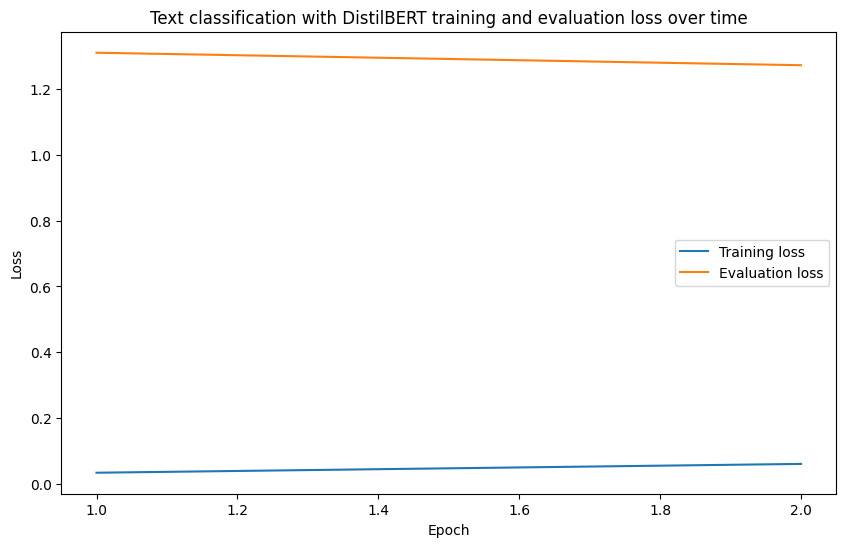

In [108]:
 # Get training history
trainer_history_all = final_trainer.state.log_history
trainer_history_metrics = trainer_history_all[:-1]
trainer_history_training_time = trainer_history_all[-1]

# Extract training and evaluation metrics
trainer_history_training_set = []
trainer_history_eval_set = []

# Loop through metrics and filter for training and eval metrics
for item in trainer_history_metrics:
    item_keys = list(item.keys())
    # Check to see if "eval" is in the keys of the item
    if any("eval" in item for item in item_keys):
        trainer_history_eval_set.append(item)
    else:
        trainer_history_training_set.append(item)

# Create pandas DataFrames for the training and evaluation metrics
trainer_history_training_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

print(f"DistilBERT Training and Evaluation Metrics:")
display(trainer_history_training_df)
display(trainer_history_eval_df)
print("\n","*"*10, "\n\n")

# Plot training and evaluation loss
plt.figure(figsize=(10, 6))
plt.plot(trainer_history_training_df["epoch"], trainer_history_training_df["loss"], label="Training loss")
plt.plot(trainer_history_eval_df["epoch"], trainer_history_eval_df["eval_loss"], label="Evaluation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Text classification with DistilBERT training and evaluation loss over time")
plt.legend()
plt.show()

## Test Final Model on OOD

In [110]:
nonfiction_tokenized = nonfiction_data.map(
    lambda x: tokenize(x, distilbert_tokenizer),
    batched=True
)

Map:   0%|          | 0/2086 [00:00<?, ? examples/s]

In [111]:
final_trainer.evaluate(nonfiction_tokenized)

{'eval_loss': 4.005915641784668,
 'eval_runtime': 5.9341,
 'eval_samples_per_second': 351.527,
 'eval_steps_per_second': 87.966,
 'epoch': 2.0}

## Error Analysis (In-Domain)

In [116]:
id_pred_output = final_trainer.predict(final_test_tokenized)
id_pred_logits = id_pred_output.predictions
id_pred_labels = id_pred_logits.argmax(axis=-1)
id_true_labels = final_test_tokenized["labels"]

id_misclassified_idx = np.where(id_pred_labels != id_true_labels)[0]

id_misclassified_samples = []

for idx in misclassified_idx:
    idx = int(idx)
    id_misclassified_samples.append({
        "text": final_test_tokenized[idx]["text"],
        "true_label": id_true_labels[idx],
        "pred_label": id_pred_labels[idx]
    })

In [117]:
id_metric = evaluate.load("mdocekal/precision_recall_fscore_accuracy", average="weighted")
id_metric.compute(predictions=id_pred_labels, references=id_true_labels)

{'precision': 0.8413488931980825,
 'recall': 0.8382923673997412,
 'fscore': 0.8383836341721324,
 'accuracy': 0.8382923673997412}

## Error Analysis (Out of Domain)

In [122]:
ood_pred_output = final_trainer.predict(nonfiction_tokenized)
ood_pred_logits = ood_pred_output.predictions
ood_pred_labels = ood_pred_logits.argmax(axis=-1)
ood_true_labels = nonfiction_tokenized["labels"]

ood_misclassified_idx = np.where(ood_pred_labels != ood_true_labels)[0]

ood_misclassified_samples = []

for idx in misclassified_idx:
    idx = int(idx)
    ood_misclassified_samples.append({
        "text": nonfiction_tokenized[idx]["text"],
        "true_label": ood_true_labels[idx],
        "pred_label": ood_pred_labels[idx]
    })

In [123]:
ood_metric = evaluate.load("mdocekal/precision_recall_fscore_accuracy", average="weighted")
ood_metric.compute(predictions=ood_pred_labels, references=ood_true_labels)

{'precision': 0.5482068720974549,
 'recall': 0.5162991371045063,
 'fscore': 0.5212163919567491,
 'accuracy': 0.5162991371045063}